**2D nonlinear diffusion-reaction system**

In [158]:
import torch
import random
import warnings
import numpy as np
import pandas as pd
import torch.nn as nn
import seaborn as sns
from sys import stderr
from scipy import stats
import torch.optim as optim
import matplotlib.pyplot as plt
import torch.nn.functional as F
from scipy.interpolate import griddata
from matplotlib.pyplot import scatter, figure
from torch.utils.data import TensorDataset, DataLoader

seed = 42
batch_size = 100
noise_scale = 0.01  # Standard deviation of the noise
num_samples = 100
num_sensors = 100

np.random.seed(seed)
torch.manual_seed(seed)

warnings.filterwarnings('ignore')
sns.set(rc={'figure.figsize':(4, 4)})

class Experiment(nn.Module):
    def __init__(self):
        super(Experiment, self).__init__()

        self.device = torch.device("cuda:0" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu")
        print(self.device)

        self.optimizer = None
        self.train_loss_history = []
        self.w_int = 1
        self.w_data = 1
        self.w_bc = 1
        self.w_param_std = 1
        self.numInputs = 2
        self.numParams = 1
        self.numOutputs = 2
        self.hidden_size = 25

        # Initialize history variables
        self.total_loss_history = []
        self.loss_interior_history = []
        self.loss_data_history = []
        self.loss_bc_history = []
        self.loss_std_history = []

        self.predicted_params = torch.zeros((batch_size,self.numParams), requires_grad=True, device=self.device)

        # We have 2 input feature
        self.b1 = nn.Linear(self.numInputs, self.hidden_size).to(self.device)
        self.b2 = nn.Linear(self.hidden_size, self.hidden_size).to(self.device)
        self.b3 = nn.Linear(self.hidden_size, self.numOutputs).to(self.device)

        self.t1 = nn.Linear(self.hidden_size, self.hidden_size).to(self.device)
        self.t2 = nn.Linear(self.hidden_size, self.hidden_size).to(self.device)
        self.t3 = nn.Linear(self.hidden_size, self.numParams).to(self.device)

        
    def forward(self, x, y, batch_size=100):
        if not torch.is_tensor(x):
            x = torch.from_numpy(x).float().to(self.device)

        if not torch.is_tensor(y):
            y = torch.from_numpy(y).float().to(self.device)
        

        # Add a dimension if it's not already there
        x = x.unsqueeze(1) if x.dim() == 1 else x
        y = y.unsqueeze(1) if y.dim() == 1 else y
      
        
        input = torch.cat((x, y), 1)
        h1 = torch.tanh(self.b1(input))
        h2 = torch.tanh(self.b2(h1))
        
        print("forward input shape", input.shape)

        prior_param_sample = torch.rand(batch_size, self.hidden_size , device=self.device).requires_grad_(True)

        t1 = torch.tanh(self.t1(prior_param_sample))
        t2 = torch.tanh(self.t2(t1))
        posterior_param_sample = self.t3(t2)
        self.predicted_params = posterior_param_sample

        output = self.b3(torch.multiply(t2, h2))

        # Split the output into u and f, each of shape [100]
        u = output[:, 0]  
        f = output[:, 1]

        return u, f



    # General formula to compute the n-th order derivative of y = f(x) with respect to x
    def compute_derivative(self, y, x, n):
        if n == 0:
            return y
        else:
            dy_dx = torch.autograd.grad(y, x, torch.ones_like(y, device= self.device),
                                        create_graph=True, retain_graph=True,
                                        allow_unused=True)[0]
        return self.compute_derivative(dy_dx, x, n - 1)


    def loss_boundary_condition(self, num_samples=100):
        num_sensors_per_side = 25
        points = torch.linspace(-1, 1, num_sensors_per_side, device = self.device)

        # Bottom border (x varies, y = -1)
        x_bottom, _ = self.forward(points, -torch.ones(num_sensors_per_side, device = self.device), num_sensors_per_side)
        
        # Top border (x varies, y = 1)
        x_top, _ = self.forward(points, torch.ones(num_sensors_per_side, device = self.device), num_sensors_per_side)
        
        # Left border (y varies, x = -1)
        y_left, _ = self.forward(-torch.ones(num_sensors_per_side, device = self.device), points, num_sensors_per_side)
        
        # Right border (y varies, x = 1)
        y_right, _ = self.forward(torch.ones(num_sensors_per_side, device = self.device), points, num_sensors_per_side)
        
        total_boundary_loss = x_bottom.sum() + x_top.sum() + y_left.sum() + y_right.sum()
        return total_boundary_loss

     
    
    
    def PDE_residual(self, x, y, lambd=0.01):
        u, _ = self.forward(x, y)
        du_dx = self.compute_derivative(u, x, 1)
        du_dy = self.compute_derivative(u, y, 1)
        d2u_dx2 = self.compute_derivative(u, x, 2)
        d2u_dy2 = self.compute_derivative(u, y, 2)
        u_squared = u ** 2  # Shape [100]
        u_squared = u_squared.view(100, 1)  
            
        # residual = lambda(d2u_dx2 + d2u_dy2) + k * (u**2) + f
        residual = torch.multiply(lambd, (d2u_dx2 + d2u_dy2)).view(100, 1) + torch.multiply(self.predicted_params, u_squared) + f.view(100, 1)
        return residual
    
    
#     def loss_data(self, num_samples=100):
#         x_data, y_data, sensor_u, sensor_f = next(iter(train_loader))
#         u_pred, f_pred = self.forward(x_data, y_data)
#         loss = torch.mean(torch.square(y_pred - y_data))
#         return loss
    
    
    def loss_interior(self, num_samples=100):
        interior_x_samples = 2*torch.rand((num_samples, 1), device=self.device).requires_grad_(True)  - 1.0
        interior_y_samples = 2*torch.rand((num_samples, 1), device=self.device).requires_grad_(True)  - 1.0
        res = self.PDE_residual(interior_x_samples, interior_y_samples)
        loss_residual = torch.mean(torch.square(res))
        return loss_residual
    
    
    def compute_losses(self):
        loss_interior = self.loss_interior()
#         loss_data = self.loss_data()
        loss_bc = self.loss_boundary_condition()
        return loss_interior, loss_bc
    
    
    def sample_parameter_posterior(self, num_samples=100):
        prior_param_samples = torch.rand(num_samples, self.hidden_size, device=self.device).requires_grad_(True)
        t1 = torch.tanh(self.t1(prior_param_samples))
        t2 = torch.tanh(self.t2(t1))
        posterior_param_samples = self.t3(t2)
        return posterior_param_samples
    
    
    def update_predicted_params(self, posterior_samples):
        mean = torch.mean(posterior_samples, dim=0)  # Compute the mean along the first axis
        std = torch.std(posterior_samples, dim=0)    # Compute the standard deviation along the first axis

        self.predicted_params = posterior_samples
        self.mean_predicted_params = mean  # Store the mean
        self.std_params = std  # Attach the standard deviation as an attribute
    
    
    def closure(self):
        self.optimizer.zero_grad()
        loss_interior, loss_bc = self.compute_losses()
        total_loss = self.w_int * loss_interior + self.w_bc * loss_bc
                   # + self.w_data * loss_data \
                   

        # Sample the parameter posterior and update self.predicted_params and self.std_params
        posterior_samples = self.sample_parameter_posterior(num_samples=100)
        self.update_predicted_params(posterior_samples)

        # Add the (Log(std))**2 term to the loss with the specified weight
        self.log_std_squared_loss = self.w_param_std * torch.mean(torch.log(self.std_params)**2)
        total_loss += self.log_std_squared_loss

        total_loss.backward(retain_graph=True)
        return total_loss
    
    
    def train(self, epochs, optimizer='Adam', num_samples=100, **kwargs):
        if optimizer == 'Adam':
            self.optimizer = torch.optim.Adam(self.parameters(), **kwargs)

        elif optimizer == 'L-BFGS':
            self.optimizer = torch.optim.LBFGS(self.parameters(), **kwargs)

        scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(self.optimizer, mode='min', factor=0.1, patience=3, verbose=True)


        # Training loop
        for epoch in range(epochs):
            self.optimizer.step(self.closure)
            if epoch % 1000 == 0:
                loss_interior, loss_bc = self.compute_losses()
                total_loss = loss_interior + loss_bc

                scheduler.step(total_loss)

                # Append losses to history
                self.total_loss_history.append(total_loss.item())
                self.loss_interior_history.append(loss_interior.item())
#                 self.loss_data_history.append(loss_data.item())
                self.loss_bc_history.append(loss_bc.item())
                self.loss_std_history.append(self.log_std_squared_loss.item())

                print(f'Epoch({optimizer}):{epoch},  Total Loss:{total_loss.item():.2f}  ' \
                        f'PDE Loss:{loss_interior.item():.2f}  ' \
                        f'BC Loss:{loss_bc.item():.2f}  ' \
                        f'IC Loss: {loss_ic.item():.2f}  ' \
                        f'Mean Predicted Param 1: {self.mean_predicted_params[0]:.2f} ' \
                        f'Std Params:{self.std_params.detach().cpu().numpy()[0]:.2f}  ' \
                        f'Std Log Loss:{self.log_std_squared_loss.item():.2f}')

In [159]:
model = Experiment()
model.to(model.device)
print("Params:", sum(p.numel() for p in model.parameters() if p.requires_grad))

mps
Params: 2103


In [160]:
model.loss_interior()

forward input shape torch.Size([100, 2])


tensor(0.0005, device='mps:0', grad_fn=<MeanBackward0>)

In [161]:
model.loss_boundary_condition()

forward input shape torch.Size([25, 2])
forward input shape torch.Size([25, 2])
forward input shape torch.Size([25, 2])
forward input shape torch.Size([25, 2])


tensor(-4.8903, device='mps:0', grad_fn=<AddBackward0>)

In [165]:
# Make sure x_train and y_train are tensors with requires_grad set to True
x_train = x_train.clone().detach().requires_grad_(True)
y_train = y_train.clone().detach().requires_grad_(True)

# Now call the PDE_residual method
residuals = model.PDE_residual(x_train, y_train)
print("Residuals:", residuals.shape)

forward input shape torch.Size([100, 2])
Residuals: torch.Size([100, 1])


In [166]:
# exact solution
def exact_solution(x, y):
    return torch.sin(torch.pi * x) * torch.sin(torch.pi * y)

# function f
def source_term(x, y, lambd=0.01, k=1.0):
    u = exact_solution(x, y)
    f = -1/50.0 * torch.pi**2 * (u) + u**2
    return f


In [167]:
def plot_u_f_distribution(x_grid, y_grid, u, f, sensor_x, sensor_y):
    fig, axes = plt.subplots(1, 2, figsize=(15, 7))

    # Subplot for 'u'
    contour1 = axes[0].contourf(x_grid.cpu().detach().numpy(), y_grid.cpu().detach().numpy(), u.cpu().detach().numpy(), cmap='jet', levels=40, vmin=-1, vmax=1)
    scatter_u = axes[0].scatter(sensor_x.cpu().detach().numpy(), sensor_y.cpu().detach().numpy(), cmap='jet', facecolors='none', marker='o', edgecolor='black', s=40, linewidths=2, label="training sample for u")
    fig.colorbar(contour1, ax=axes[0])
    axes[0].set_title('Distribution of u')
    axes[0].set_xlabel('x')
    axes[0].set_ylabel('y')
    axes[0].legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), fancybox=True, shadow=True)

    # Subplot for 'f'
    contour2 = axes[1].contourf(x_grid.cpu().detach().numpy(), y_grid.cpu().detach().numpy(), f.cpu().detach().numpy(), cmap='jet', levels=40, vmin=0, vmax=1)
    scatter_f = axes[1].scatter(sensor_x.cpu().detach().numpy(), sensor_y.cpu().detach().numpy(),  cmap='jet', color='black', marker='x', s=40, linewidths=2, label="training sample for s")
    fig.colorbar(contour2, ax=axes[1])
    axes[1].set_title('Distribution of f')
    axes[1].set_xlabel('x')
    axes[1].set_ylabel('y')
    axes[1].legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), fancybox=True, shadow=True)

    plt.tight_layout()
    plt.show()

In [168]:
def sample_dataset_nonlinear(noise_scale=0.01, num_samples=100, device='mps', lambd=0.01, k=0.5):    
    x = torch.linspace(-1, 1, num_samples, device=device) # Space domain for x
    y = torch.linspace(-1, 1, num_samples, device=device) # Space domain for y
    
    # Create a 2D grid of x and y values
    x_grid, y_grid = torch.meshgrid(x, y, indexing="ij")

    u = exact_solution(x_grid, y_grid)
    f = source_term(x_grid, y_grid)

    # Generate random sensor locations
    indices = np.random.choice(x_grid.numel(), num_sensors, replace=False)
    sensor_x = x_grid.reshape(-1)[indices]
    sensor_y = y_grid.reshape(-1)[indices]

    # Extracting sensor values for u and f
    sensor_u = u.reshape(-1)[indices]
    sensor_f = f.reshape(-1)[indices]
    
    plot_u_f_distribution(x_grid, y_grid, u, f, sensor_x, sensor_y)

    return x, y, sensor_u, sensor_f 


In [169]:
def create_train_dataset(device='mps', batch_size=batch_size):
    # Generate the data
    x_train, y_train, sensor_u, sensor_f = sample_dataset_nonlinear(noise_scale=noise_scale, num_samples=num_samples, device=device, lambd=0.01, k=0.5)

    # Add Gaussian noise to sensor data
    sensor_u_noisy = sensor_u + torch.randn(sensor_u.size(), device=device) * noise_scale
    sensor_f_noisy = sensor_f + torch.randn(sensor_f.size(), device=device) * noise_scale
    
    train_dataset = TensorDataset(x_train, y_train, sensor_u_noisy, sensor_f_noisy)
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

    return train_loader, sensor_u_noisy, sensor_f_noisy

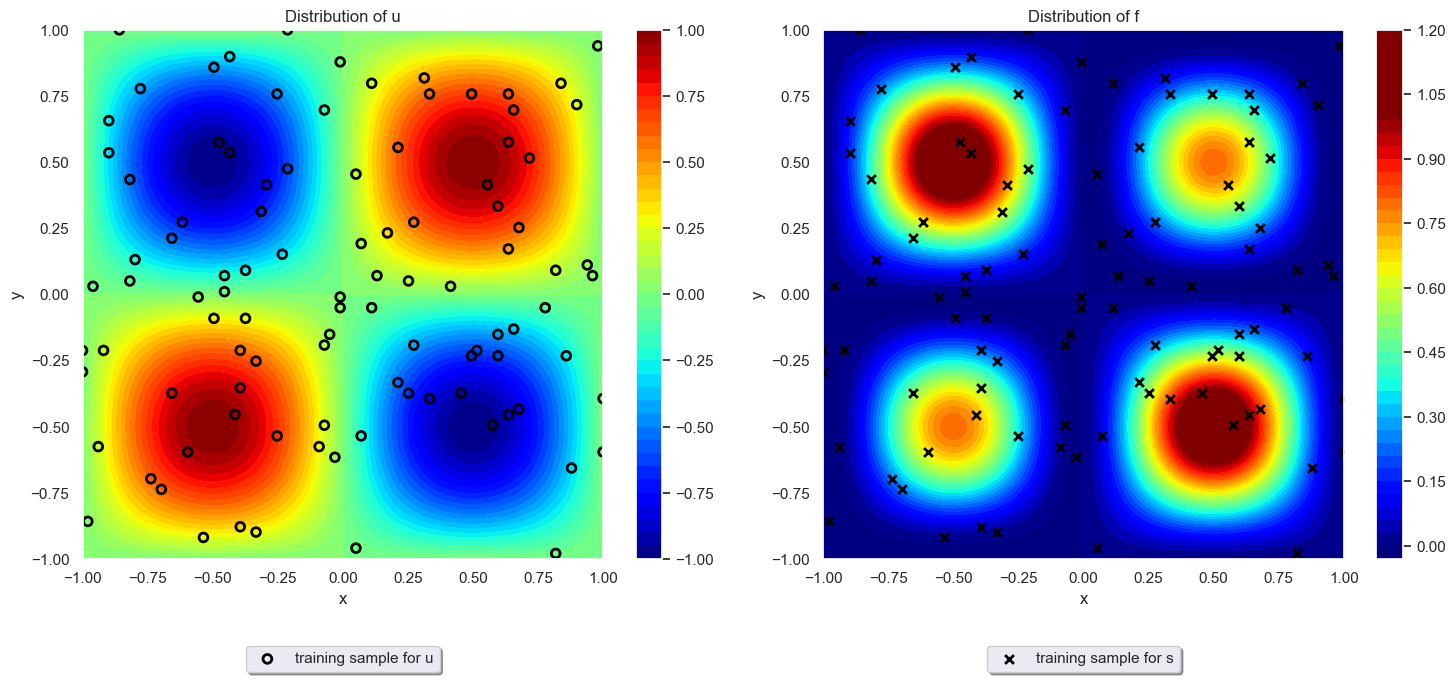

In [170]:
train_loader, sensor_u_noisy, sensor_f_noisy = create_train_dataset()

In [64]:
model = Experiment()
model.to(model.device)
print("Params:", sum(p.numel() for p in model.parameters() if p.requires_grad))

mps
Params: 2103


mps
Params: 2103


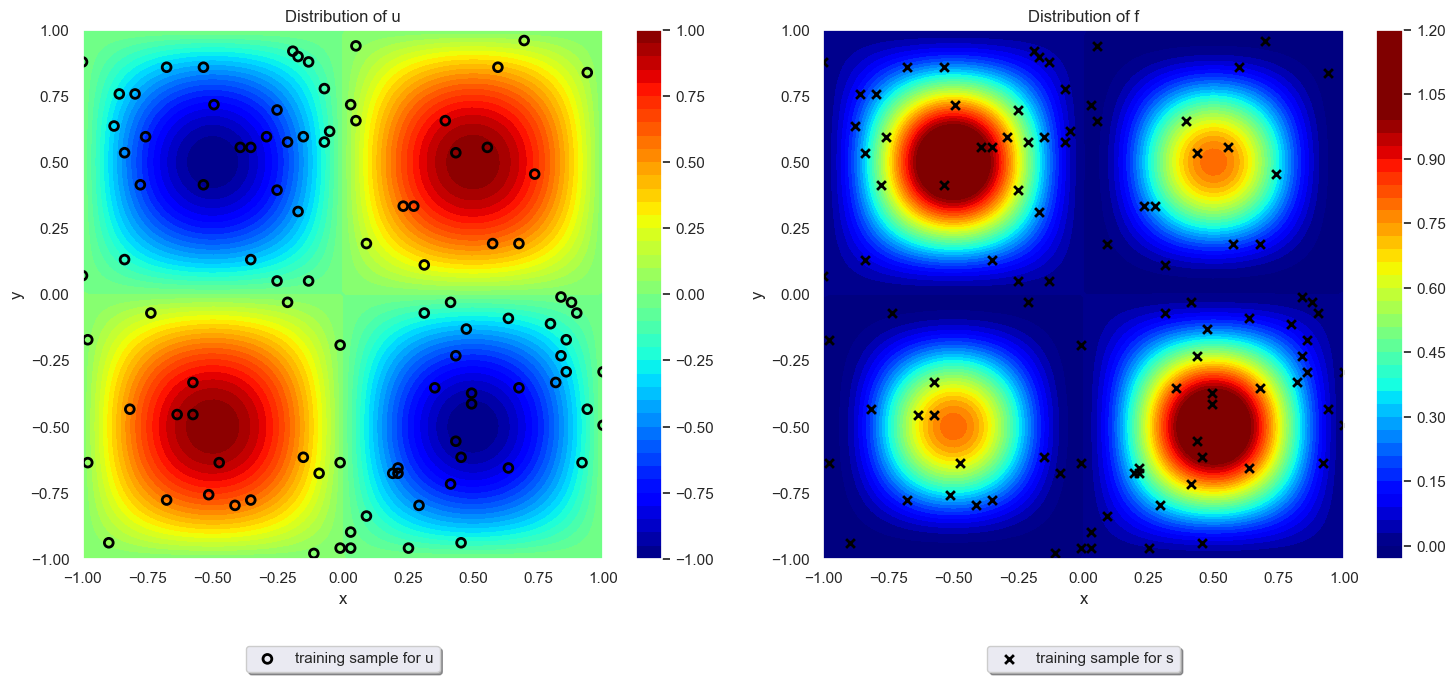

Input shapes:
x_train: torch.Size([100])
y_train: torch.Size([100])
u_train: torch.Size([100])
f_train: torch.Size([100])
forward input shape torch.Size([100, 2])
Outputs from the model:
u: torch.Size([100])
f: torch.Size([100])


In [96]:
# Initialize the model and move it to the appropriate device
model = Experiment()
model.to(model.device)

# Print the number of trainable parameters in the model
print("Params:", sum(p.numel() for p in model.parameters() if p.requires_grad))

# Using the DataLoader to get a batch of data
train_loader, sensor_u_noisy, sensor_f_noisy = create_train_dataset(device=model.device)

# Fetch one batch of data
for batch in train_loader:
    x_train, y_train, u_train, f_train = batch
    break  # We only take one batch for demonstration

# Check input shapes
print("Input shapes:")
print("x_train:", x_train.shape)
print("y_train:", y_train.shape)
print("u_train:", u_train.shape)
print("f_train:", f_train.shape)

# Forward pass to check if everything is working fine
u, f = model(x_train, y_train)
print("Outputs from the model:")
print("u:", u.shape)
print("f:", f.shape)


In [97]:
# Explicitly calling the forward method
u, f = model.forward(x_train, y_train)  # Using .forward() directly
print("Outputs from the model using .forward():")
print("u:", u.shape)
print("f:", f.shape)


forward input shape torch.Size([100, 2])
Outputs from the model using .forward():
u: torch.Size([100])
f: torch.Size([100])


In [87]:
# def sample_dataset_nonlinear(noise_scale=0.01, num_samples=100, device='mps', lambd=0.01, k=0.5):    
#     x = torch.linspace(-1, 1, num_samples, device=device)
#     y = torch.linspace(-1, 1, num_samples, device=device)
    
#     x_grid, y_grid = torch.meshgrid(x, y, indexing="ij")
#     X = x_grid.reshape(-1, 1)
#     Y = y_grid.reshape(-1, 1)

#     u = exact_solution(x_grid, y_grid)
#     f = source_term(x_grid, y_grid)

#     indices = np.random.choice(x_grid.numel(), num_sensors, replace=False)
#     sensor_x = x_grid.reshape(-1)[indices]
#     sensor_y = y_grid.reshape(-1)[indices]
#     sensor_u = u.reshape(-1)[indices]
#     sensor_f = f.reshape(-1)[indices]
    
#     plot_u_f_distribution(x_grid, y_grid, u, f, sensor_x, sensor_y)

#     return sensor_x, sensor_y, sensor_u, sensor_f  # Updated return to provide sliced x and y

# def create_train_dataset(device='mps', batch_size=batch_size):
#     x_train, y_train, sensor_u, sensor_f = sample_dataset_nonlinear(noise_scale=noise_scale, num_samples=num_samples, device=device, lambd=0.01, k=0.5)
#     sensor_u_noisy = sensor_u + torch.randn(sensor_u.size(), device=device) * noise_scale
#     sensor_f_noisy = sensor_f + torch.randn(sensor_f.size(), device=device) * noise_scale
    
#     train_dataset = TensorDataset(x_train, y_train, sensor_u_noisy, sensor_f_noisy)
#     train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

#     return train_loader, sensor_u_noisy, sensor_f_noisy
